In [9]:
import torch
import numpy as np
import skimage.io
import skimage
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import random
import pickle
%matplotlib inline
%env CUDA_VISIBLE_DEVICES= 6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
# load data
train_X = np.load("all_img_flip.npy")
train_attr = pd.read_csv("./hw4_data/train.csv")
test_attr = pd.read_csv("./hw4_data/test.csv")

smiling_attr = np.hstack((np.repeat(np.array(train_attr["Smiling"]),2) 
                          ,np.repeat(np.array(test_attr["Smiling"]),2)
                         ))
# smiling_attr = np.hstack((np.array(train_attr["Smiling"])
#                           ,np.array(test_attr["Smiling"]))
#                          )

In [3]:
# type transform
img_X = torch.from_numpy(train_X).type(torch.FloatTensor)
class_X = torch.from_numpy(smiling_attr).type(torch.FloatTensor).view(-1,1,1,1)

In [4]:
class Generator(nn.Module):
    def __init__(self, figsize=64):
        super(Generator, self).__init__()
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 101, figsize * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(figsize * 8, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(figsize * 4, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(figsize * 2, figsize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(figsize, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
            
    def forward(self, X):
        output = self.decoder(X)/2.0+0.5
        return output
    
class Discriminator(nn.Module):
    def __init__(self, figsize=64):
        super(Discriminator, self).__init__()
        self.decoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, figsize, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(figsize, figsize * 2, 4, 2, 1),
            nn.BatchNorm2d(figsize * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(figsize * 2, figsize * 4, 4, 2, 1),
            nn.BatchNorm2d(figsize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(figsize * 4, figsize * 8, 4, 2, 1),
            nn.BatchNorm2d(figsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(figsize * 8, figsize *1, 4, 1, 0),
        )
        self.fc_dis = nn.Linear(figsize *1, 1)
        # aux-classifier fc
        self.fc_aux = nn.Linear(figsize *1, 1) # one class
        
        # softmax and sigmoid
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        decode_output = self.decoder(X)

        flat = decode_output.view(-1,64)
        fc_dis = self.fc_dis(flat)
        fc_aux = self.fc_aux(flat)
        
        realfake = self.sigmoid(fc_dis)
        classes = self.sigmoid(fc_aux)
        
        return realfake, classes

In [5]:
random.seed(38)
torch.manual_seed(38)
# use for random generation
up = np.ones(10)
down = np.zeros(10)
fixed_class = np.hstack((up,down))
fixed_class = torch.from_numpy(fixed_class).view(20,1,1,1).type(torch.FloatTensor)
fixed_noise = torch.randn(10, 100, 1, 1)
fixed_noise = torch.cat((fixed_noise,fixed_noise))
fixed_input = Variable(torch.cat((fixed_noise, fixed_class),1)).cuda()

In [6]:
# loss functions
dis_criterion = nn.BCELoss()
aux_criterion = nn.BCELoss()

# training
latent_size = 100
BATCH_SIZE = 64
G = Generator()
D = Discriminator()
G.cuda()
D.cuda()

# setup optimizer
beta_1 = 0.5
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(beta_1,0.999))
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(beta_1,0.999))


D_loss_list = []
G_loss_list = []
D_fake_acc_list = []
D_real_acc_list = []

D_fake_class_list = []
D_real_class_list = []

for epoch in range(200):
    print("Epoch:", epoch+1)
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    D_fake_acc = 0.0
    D_real_acc = 0.0
    D_fake_class = 0.0
    D_real_class = 0.0
    total_length = len(train_X)
    # shuffle
    perm_index = torch.randperm(total_length)
    train_X_sfl = img_X[perm_index]
    train_class_sfl = class_X[perm_index]
    
#     # learning rate decay
#     if (epoch+1) == 5:
#         optimizerG.param_groups[0]['lr'] /= 2
#         optimizerD.param_groups[0]['lr'] /= 2
#         print("learning rate change!")

    if (epoch+1) == 15:
        optimizerG.param_groups[0]['lr'] /= 2
        optimizerD.param_groups[0]['lr'] /= 2
        print("learning rate change!")
    
    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
        for _ in range(1):    
            # zero the parameter gradients
            D.zero_grad()
            input_X = train_X_sfl[index:index+BATCH_SIZE]
            intput_class = train_class_sfl[index:index+BATCH_SIZE]

            #### train with real image -> ground truth = real label
            real_image = Variable(input_X.cuda()) # use GPU 
            real_class = Variable(intput_class.cuda())
            real_label = Variable(torch.ones((BATCH_SIZE))).cuda()
            dis_ouput, aux_output = D(real_image)
            D_real_dis_loss = dis_criterion(dis_ouput, real_label.view(BATCH_SIZE,1))
            D_real_aux_loss = aux_criterion(aux_output, real_class.view(BATCH_SIZE,1))
            D_real_acc += np.mean(((dis_ouput > 0.5).cpu().data.numpy() == real_label.cpu().data.numpy()))
            D_real_loss = (D_real_dis_loss + D_real_aux_loss)/2
            D_real_class += D_real_aux_loss.data[0]

            #### train with fake image -> ground truth = fake label
            noise = torch.randn(BATCH_SIZE, 100, 1, 1)
            fake_class = torch.from_numpy(np.random.randint(2,size=BATCH_SIZE)).view(BATCH_SIZE,1,1,1)
            intput_vector =Variable(torch.cat((noise,fake_class.type(torch.FloatTensor)),1)).cuda()

            fake_label = Variable(torch.zeros((BATCH_SIZE))).cuda()
            fake_class = Variable(fake_class.type(torch.FloatTensor)).cuda()

            fake_image = G(intput_vector)
            dis_output, aux_output = D(fake_image.detach())
            D_fake_dis_loss = dis_criterion(dis_output, fake_label.view(BATCH_SIZE,1))
            D_fake_aux_loss = aux_criterion(aux_output, fake_class.view(BATCH_SIZE,1))
            D_fake_loss = (D_fake_dis_loss + D_fake_aux_loss)/2
            D_fake_acc += np.mean(((dis_output > 0.5).cpu().data.numpy() == fake_label.cpu().data.numpy()))
            D_fake_class += D_fake_aux_loss.data[0]
            # update D
            D_train_loss = D_real_loss + D_fake_loss
            D_train_loss.backward()
            epoch_D_loss+=(D_train_loss.data[0])

            optimizerD.step()
        
        #### train Generator
        for _ in range(2):
            G.zero_grad()
            # generate fake image
            noise = torch.randn(BATCH_SIZE, 100, 1, 1)
            fake_class = torch.from_numpy(np.random.randint(2,size=BATCH_SIZE)).view(BATCH_SIZE,1,1,1)

            intput_vector = Variable(torch.cat((noise,fake_class.type(torch.FloatTensor)),1)).cuda()

            fake_class = Variable(fake_class.type(torch.FloatTensor)).cuda()
            fake_label_for_G = Variable(torch.ones((BATCH_SIZE))).cuda()

            fake_image = G(intput_vector)
            dis_output, aux_output = D(fake_image)
            G_dis_loss = dis_criterion(dis_output, fake_label_for_G.view(BATCH_SIZE,1))
            G_aux_loss = aux_criterion(aux_output, fake_class.view(BATCH_SIZE,1))
            G_train_loss = G_dis_loss + G_aux_loss
            G_train_loss.backward()
            optimizerG.step()
        epoch_G_loss += (G_train_loss.data[0])
    print("training D Loss:",epoch_D_loss/(total_length))
    print("training G Loss:", epoch_G_loss/(total_length))
    D_loss_list.append(epoch_D_loss/(total_length))
    G_loss_list.append(epoch_G_loss/(total_length))
    
    print("D_real_dis_acc:", D_real_acc/(total_length/BATCH_SIZE))
    print("D_fake_dis_acc:", D_fake_acc/(total_length/BATCH_SIZE))
    print("D_real_aux_loss:", D_real_class/(total_length/BATCH_SIZE))
    print("D_fake_aux_loss:", D_fake_class/(total_length/BATCH_SIZE))
    D_real_acc_list.append(D_real_acc/(total_length/BATCH_SIZE))
    D_fake_acc_list.append(D_fake_acc/(total_length/BATCH_SIZE))    
    D_real_class_list.append(D_real_class/(total_length/BATCH_SIZE))
    D_fake_class_list.append(D_fake_class/(total_length/BATCH_SIZE))
    # evaluation
    G.eval()
    fixed_img_output = G(fixed_input)
    G.train()
    torchvision.utils.save_image(fixed_img_output.cpu().data, './ACGAN_output2/fig3_3_'+str(epoch+1)+'.jpg',nrow=10)
    
torch.save(G.state_dict(), "./models/ACG2_model.pkt")

Epoch: 1
training D Loss: 0.013810472757079428
training G Loss: 0.01476160552085994
D_real_dis_acc: 0.49217521878885995
D_fake_dis_acc: 0.5089509866028483
D_real_aux_loss: 0.31116990422612917
D_fake_aux_loss: 0.04692254285770032
Epoch: 2
training D Loss: 0.012760805539250674
training G Loss: 0.01213192477001046
D_real_dis_acc: 0.5227704652636025
D_fake_dis_acc: 0.5351000680415757
D_real_aux_loss: 0.23725076348931334
D_fake_aux_loss: 0.01537240275555115
Epoch: 3
training D Loss: 0.012637083444866977
training G Loss: 0.011879824916015459
D_real_dis_acc: 0.5270875859318177
D_fake_dis_acc: 0.53805635719481
D_real_aux_loss: 0.22139696378334883
D_fake_aux_loss: 0.01818474078534459
Epoch: 4
training D Loss: 0.012498418679586091
training G Loss: 0.012136807826097823
D_real_dis_acc: 0.5384904155228644
D_fake_dis_acc: 0.5506792426268741
D_real_aux_loss: 0.20826954449032276
D_fake_aux_loss: 0.019648565294310676
Epoch: 5
training D Loss: 0.012238626622495842
training G Loss: 0.013035353670059601
D

training D Loss: 0.002969177263403619
training G Loss: 0.07605291035436504
D_real_dis_acc: 0.9405222777504048
D_fake_dis_acc: 0.9350320264658267
D_real_aux_loss: 0.02780552011406094
D_fake_aux_loss: 0.022275277641546794
Epoch: 38
training D Loss: 0.0030651907083324038
training G Loss: 0.0766640968916381
D_real_dis_acc: 0.9347856690363905
D_fake_dis_acc: 0.9312780084934656
D_real_aux_loss: 0.028351987166328165
D_fake_aux_loss: 0.0230059814230689
Epoch: 39
training D Loss: 0.0030710972723274697
training G Loss: 0.07732394315628043
D_real_dis_acc: 0.9368151850026982
D_fake_dis_acc: 0.930949531920884
D_real_aux_loss: 0.027634779818324396
D_fake_aux_loss: 0.023253795175599553
Epoch: 40
training D Loss: 0.0029161198951671236
training G Loss: 0.07771897047890258
D_real_dis_acc: 0.9407217099551864
D_fake_dis_acc: 0.9365570962670984
D_real_aux_loss: 0.026870721083369794
D_fake_aux_loss: 0.0227511971669272
Epoch: 41
training D Loss: 0.0029520547288061113
training G Loss: 0.07872095068119588
D_re

training D Loss: 0.002139780166066416
training G Loss: 0.09278330043039022
D_real_dis_acc: 0.9569343750733207
D_fake_dis_acc: 0.9541540555125407
D_real_aux_loss: 0.018060529983597067
D_fake_aux_loss: 0.019355040554873026
Epoch: 74
training D Loss: 0.002141860767170909
training G Loss: 0.09513049218628397
D_real_dis_acc: 0.9596443067971188
D_fake_dis_acc: 0.9542009807371953
D_real_aux_loss: 0.01961235040659154
D_fake_aux_loss: 0.019850360682299863
Epoch: 75
training D Loss: 0.0022060003978517343
training G Loss: 0.09440277661969221
D_real_dis_acc: 0.9554327678843763
D_fake_dis_acc: 0.9529691935900143
D_real_aux_loss: 0.020355448792076385
D_fake_aux_loss: 0.020213167427418754
Epoch: 76
training D Loss: 0.002138679462495351
training G Loss: 0.09564610288473255
D_real_dis_acc: 0.9569461063794843
D_fake_dis_acc: 0.9542948311865043
D_real_aux_loss: 0.01843711316167264
D_fake_aux_loss: 0.019228076750250307
Epoch: 77
training D Loss: 0.0021408766326780656
training G Loss: 0.096472587429183
D_r

training D Loss: 0.00200669751290507
training G Loss: 0.10089479276781022
D_real_dis_acc: 0.9612866896600267
D_fake_dis_acc: 0.9579198047910654
D_real_aux_loss: 0.01711976879195114
D_fake_aux_loss: 0.0203168059815202
Epoch: 110
training D Loss: 0.0020178107777867175
training G Loss: 0.10171393766509426
D_real_dis_acc: 0.9618028671312264
D_fake_dis_acc: 0.9582365500574834
D_real_aux_loss: 0.01705509084017699
D_fake_aux_loss: 0.02040798403644866
Epoch: 111
training D Loss: 0.002157735330447111
training G Loss: 0.100774774978124
D_real_dis_acc: 0.9594566058985008
D_fake_dis_acc: 0.9559372140494122
D_real_aux_loss: 0.017361174492469485
D_fake_aux_loss: 0.01850628407855541
Epoch: 112
training D Loss: 0.0018760954019675425
training G Loss: 0.10163468693132338
D_real_dis_acc: 0.9641491283639521
D_fake_dis_acc: 0.9606297365148636
D_real_aux_loss: 0.01704530341557744
D_fake_aux_loss: 0.020039091373212636
Epoch: 113
training D Loss: 0.0020401780315688193
training G Loss: 0.10242094955846315
D_re

training D Loss: 0.0019523515251407956
training G Loss: 0.10219089576495488
D_real_dis_acc: 0.9607001243518454
D_fake_dis_acc: 0.9582952065883016
D_real_aux_loss: 0.016209258027683283
D_fake_aux_loss: 0.016732846421666055
Epoch: 146
training D Loss: 0.002097432466586523
training G Loss: 0.10294480410818956
D_real_dis_acc: 0.9577907604232655
D_fake_dis_acc: 0.9556908566199761
D_real_aux_loss: 0.016468626190805007
D_fake_aux_loss: 0.019041208619524286
Epoch: 147
training D Loss: 0.001967599365640138
training G Loss: 0.10155107301721568
D_real_dis_acc: 0.9607235869641726
D_fake_dis_acc: 0.9577672978109383
D_real_aux_loss: 0.016067802021639384
D_fake_aux_loss: 0.01748792741555082
Epoch: 148
training D Loss: 0.0019894201476940215
training G Loss: 0.10176727203752123
D_real_dis_acc: 0.9616034349264447
D_fake_dis_acc: 0.958658877079374
D_real_aux_loss: 0.01551836335757585
D_fake_aux_loss: 0.01807189786621393
Epoch: 149
training D Loss: 0.0020258085811396837
training G Loss: 0.1009038073322756

training D Loss: 0.001953161688293727
training G Loss: 0.10571463994112129
D_real_dis_acc: 0.9599493207573732
D_fake_dis_acc: 0.9586823396917012
D_real_aux_loss: 0.016146867894456435
D_fake_aux_loss: 0.018085895809063536
Epoch: 182
training D Loss: 0.0017371078931645294
training G Loss: 0.10717771606469255
D_real_dis_acc: 0.966295957391896
D_fake_dis_acc: 0.9633162056263345
D_real_aux_loss: 0.014810925055256684
D_fake_aux_loss: 0.0174001172209703
Epoch: 183
training D Loss: 0.001844084394864476
training G Loss: 0.10945580890380566
D_real_dis_acc: 0.9647474249782971
D_fake_dis_acc: 0.9616855540695901
D_real_aux_loss: 0.01548949647779609
D_fake_aux_loss: 0.019425336079833565
Epoch: 184
training D Loss: 0.0019718166000203914
training G Loss: 0.10661721864603296
D_real_dis_acc: 0.96181459843739
D_fake_dis_acc: 0.9584477135684287
D_real_aux_loss: 0.016141530334979996
D_fake_aux_loss: 0.019985370248805864
Epoch: 185
training D Loss: 0.0020312931078951425
training G Loss: 0.10437519409888057


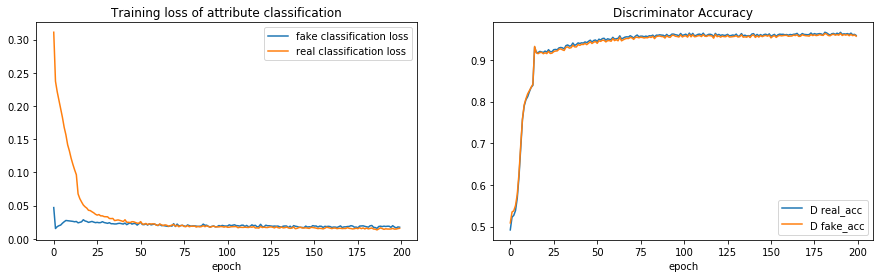

In [14]:
with open("ACGAN_D_fake_class_list.pkl", "wb") as f:
    pickle.dump(D_fake_class_list,f)
with open("ACGAN_D_real_class_list.pkl", "wb") as f:
    pickle.dump(D_real_class_list,f)
with open("ACGAN_D_real_acc_list.pkl", "wb") as f:
    pickle.dump(D_real_acc_list,f)
with open("ACGAN_D_fake_acc_list.pkl", "wb") as f:
    pickle.dump(D_fake_acc_list,f)
    
# plot loss
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(D_fake_class_list, label="fake classification loss")
plt.plot(D_real_class_list, label="real classification loss")
plt.title("Training loss of attribute classification")
plt.xlabel("epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(D_real_acc_list, label="D real_acc")
plt.plot(D_fake_acc_list, label="D fake_acc")
plt.title("Discriminator Accuracy")
plt.xlabel("epoch")
plt.legend()
plt.savefig("./ACGAN_output2/fig3_2.jpg")
plt.show()